<a href="https://colab.research.google.com/github/muskanp957/OCR-optical-character-recognition/blob/main/Flight_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flight-price-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1957837%2F3228623%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240722%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240722T085325Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D977f0d8ce973c563b7a02580e0e33e357ed630d5c8654fba9fceb08784bb72312f9a2dbe1cbaa5f85328a63826cdd356ff8c555d43e8bd43938284790592de58b0e1b935fc90b801bf31ca775e9fd163728cc10847161ac3db133a601f5c2804f7d3f6cb5f189173b0457af5a0dd1bb5b6ae0557fb12704dbc6a95cbea82b4e74808fdfd415d7efc5b1ad5bbdbd54206d9533f1f00195d005dc6b55415425e68cf7d5f35e387225cb28cc43ffbc761ae41e762e2dae7f2445a5ca37ace6ef6aaf22ad8de4efec642f14ff50f1358303c59be9f42a4771393fae79178fa25021ac8542eeb67a574c785ee6beeed1dbc9ef48f896bc2e8c3dfdbb8204a4170a04d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4360218 bytes downloaded
Downloaded and uncompressed: flight-price-prediction
Data source import complete.


<div style="color:white;
            display:fill;
            border-radius:15px;
            background-color:skyblue;
            font-size:100%;
            font-family:Verdana;
            letter-spacing:1px">
    <h2 style='padding: 20px;
              color:black;
              text-align:center;'>
        FLIGHT FARE PREDICTION
    </h2>
    </div>

In [ ]:
# Importing all the Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flight-price-prediction/Clean_Dataset.csv
/kaggle/input/flight-price-prediction/business.csv
/kaggle/input/flight-price-prediction/economy.csv


In [ ]:
# Lets see what is in the Data
df=pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [ ]:
df.columns = df.columns.str.strip()
df = df.drop('Unnamed: 0', axis=1, errors='ignore')


In [ ]:
# A Quick Information abou the Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [ ]:
# Stastical Description of Data
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Select only the numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix on numerical columns
correlation_matrix = numerical_df.corr().T

print(correlation_matrix)

           duration  days_left     price
duration   1.000000  -0.039157  0.204222
days_left -0.039157   1.000000 -0.091949
price      0.204222  -0.091949  1.000000


In [ ]:
# Size of the data
df.shape

(300153, 11)

In [ ]:
df1=df.groupby(['flight','airline'],as_index=False).count()
df1.airline.value_counts()

airline
Indigo       704
Air_India    218
GO_FIRST     205
SpiceJet     186
Vistara      133
AirAsia      115
Name: count, dtype: int64

<b> Indigo becaming as a most popular Airline

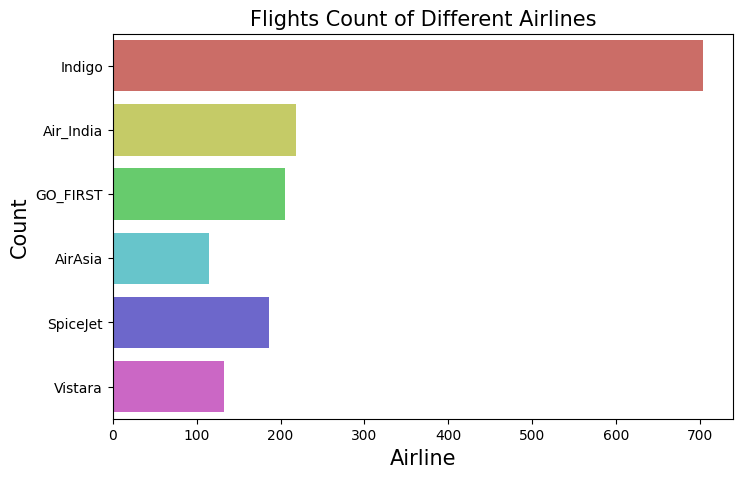

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(df1['airline'],palette='hls')
plt.title('Flights Count of Different Airlines',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

In [ ]:
df2=df.groupby(['flight','airline','class'],as_index=False).count()
df2['class'].value_counts()

class
Economy     1560
Business     295
Name: count, dtype: int64

<b> Most of the Airlines has Economic Class as common

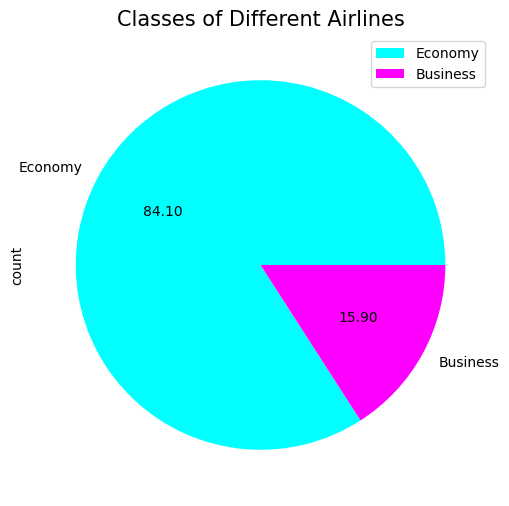

In [ ]:
plt.figure(figsize=(8,6))
df2['class'].value_counts().plot(kind='pie',textprops={'color':'black'},autopct='%.2f',cmap='cool')
plt.title('Classes of Different Airlines',fontsize=15)
plt.legend(['Economy','Business'])
plt.show()

<b> Does price vary with Airlines?</b>

<p>
    
<ul>
    <li>As we can see Vistara has Maximum Price range</li>
    <li>Vistara and Air_India Airlines Have Maximum Price when compared to Others</li>
    <li>SpiceJet , AirAsia , GO_First and Indigo has some what equal prices</li>  
    
</ul>
</p>

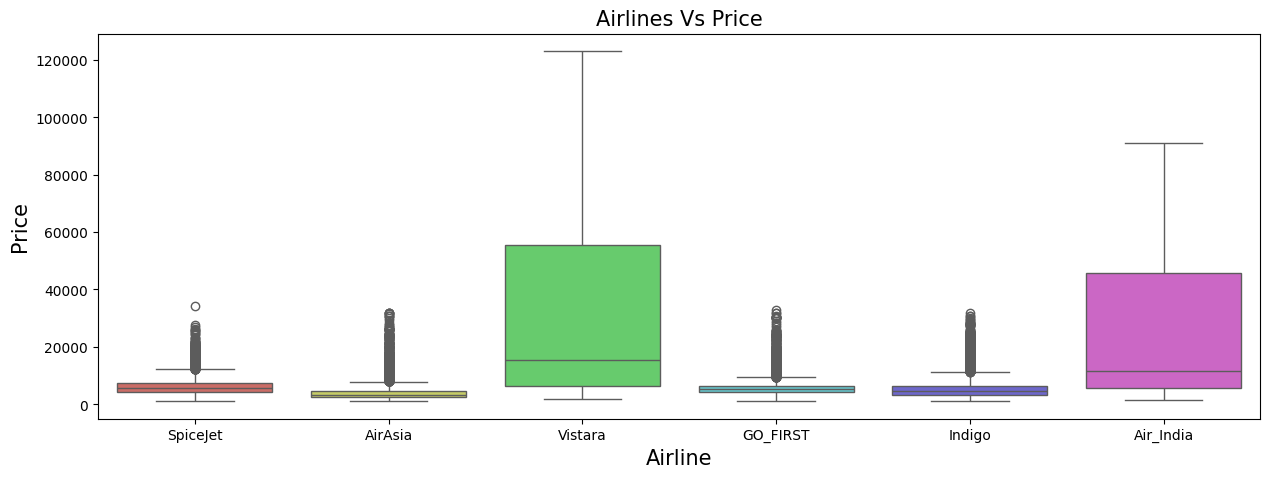

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['airline'],y=df['price'],palette='hls')
plt.title('Airlines Vs Price',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<p>
    <b> How Does the Ticket Price vary between Economy and Business Class?</b>
   
<ul>
    <li>Ticket Price is Maximum for Bussiness Class When compared to Economy Class</li>
</ul>
    </p>

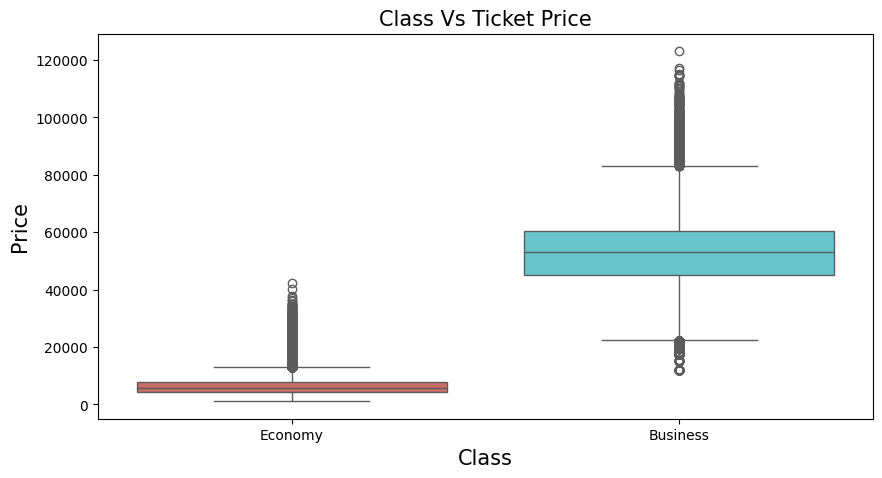

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='class',y='price',data=df,palette='hls')
plt.title('Class Vs Ticket Price',fontsize=15)
plt.xlabel('Class',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<b> How Does the Ticket Price vary with the number of stops of a Flight?</b>

<p>
<ul><li>Flights having one stop has maximum ticket price</li></ul>
</p>

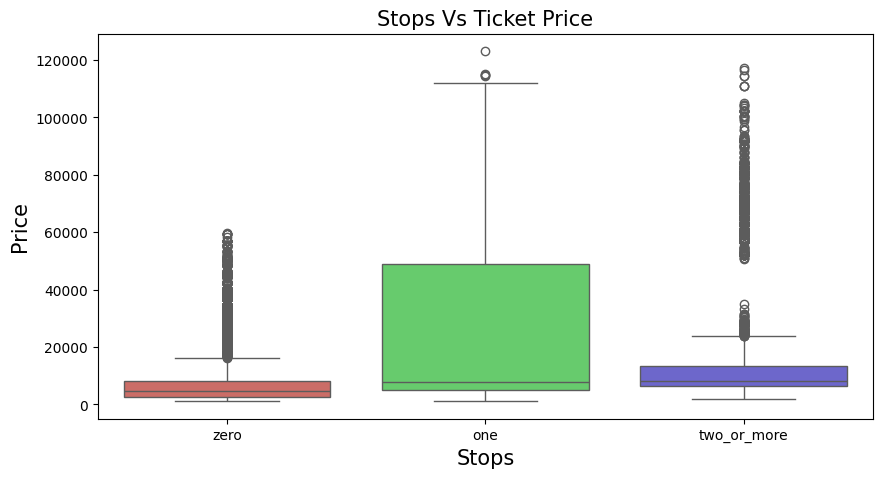

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='stops',y='price',data=df,palette='hls')
plt.title('Stops Vs Ticket Price',fontsize=15)
plt.xlabel('Stops',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

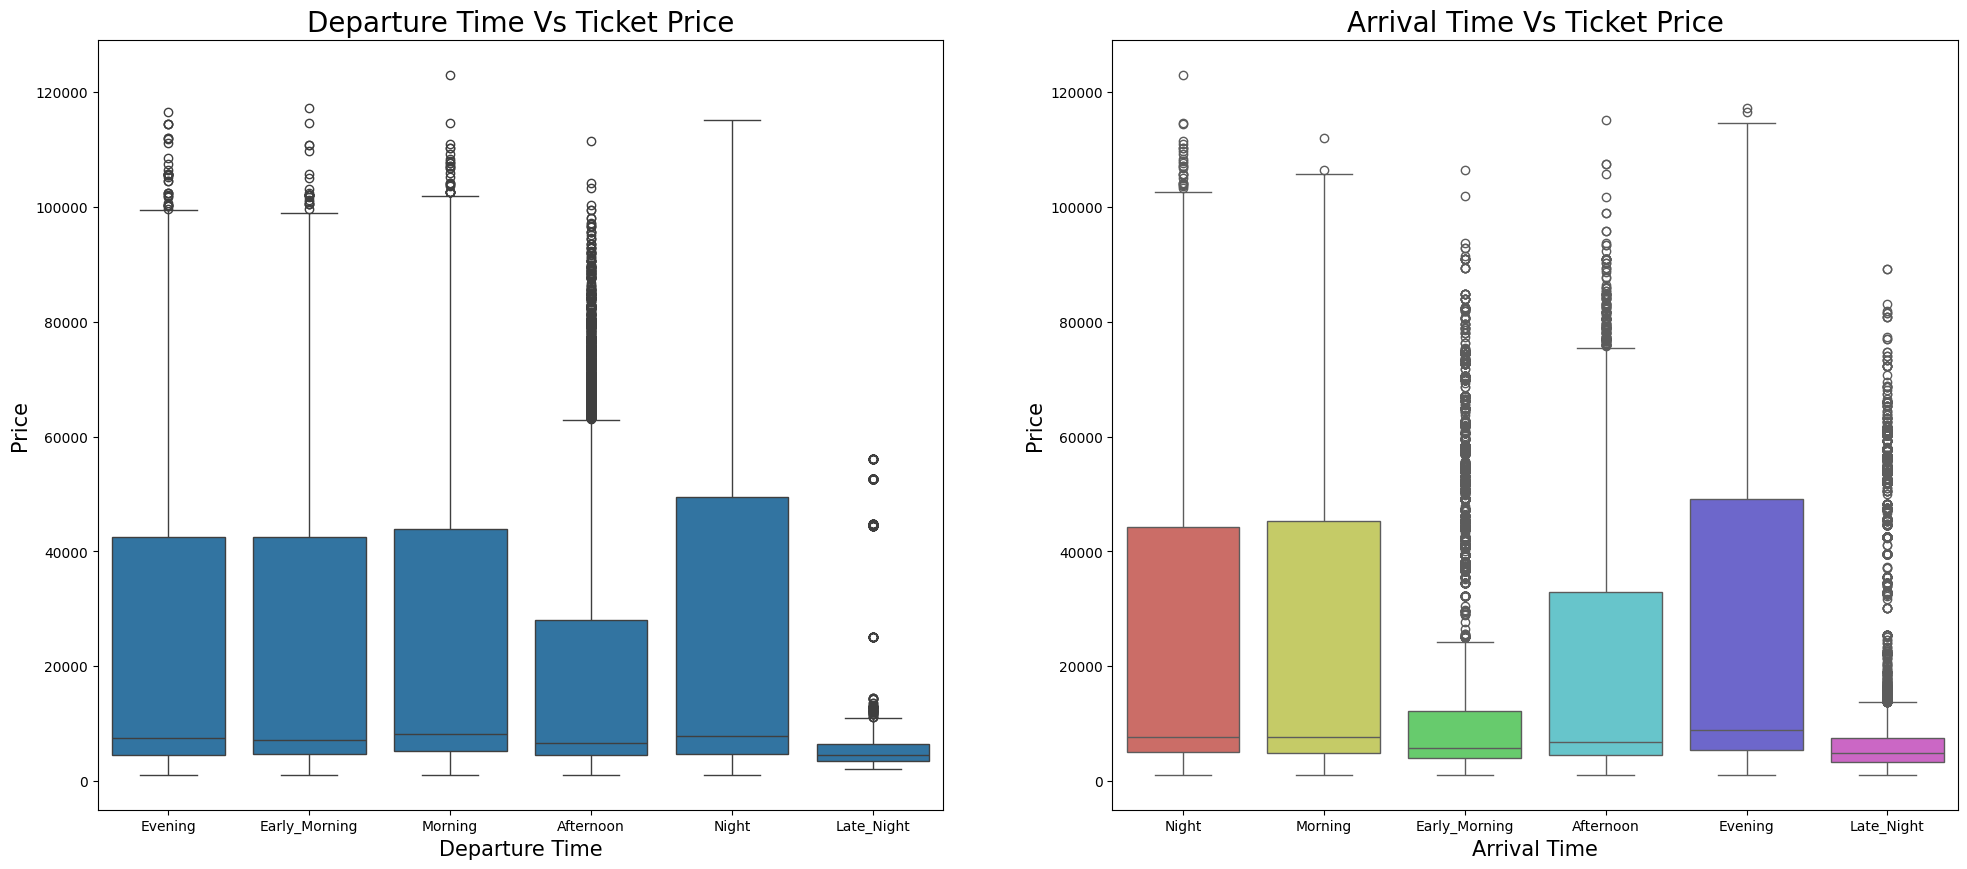

In [ ]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='departure_time',y='price',data=df)
plt.title('Departure Time Vs Ticket Price',fontsize=20)
plt.xlabel('Departure Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='arrival_time',y='price',data=df,palette='hls')
plt.title('Arrival Time Vs Ticket Price',fontsize=20)
plt.xlabel('Arrival Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<p>
<b> How the price changes with change in Source city and Destination city?</b><br>
    
<b>1. Source City Vs Ticket Price</b>

   <li> Ticket Price is More for the Flights whose Source City is Kolkata</li>
   <li>Ticket Price is almost equal for flights Having Source Cities as Mumbai and chennai , Hyderabad and Bangalore</li>
    <li> Ticket Price is Low for the Flights Having Source City as Delhi</li>
    

<b>2. Destination City Vs Ticket Price</b>

   <li> Ticket Price is More for the Flights whose Destination City is kolkata and Chennai</li>
   <li> Ticket Price is almost equal for flights Having Destination Cities as Mumbai and Bangalore</li>
   <li>Ticket Price is Low for the Flights Having Destination City as Delhi</li>
</p>

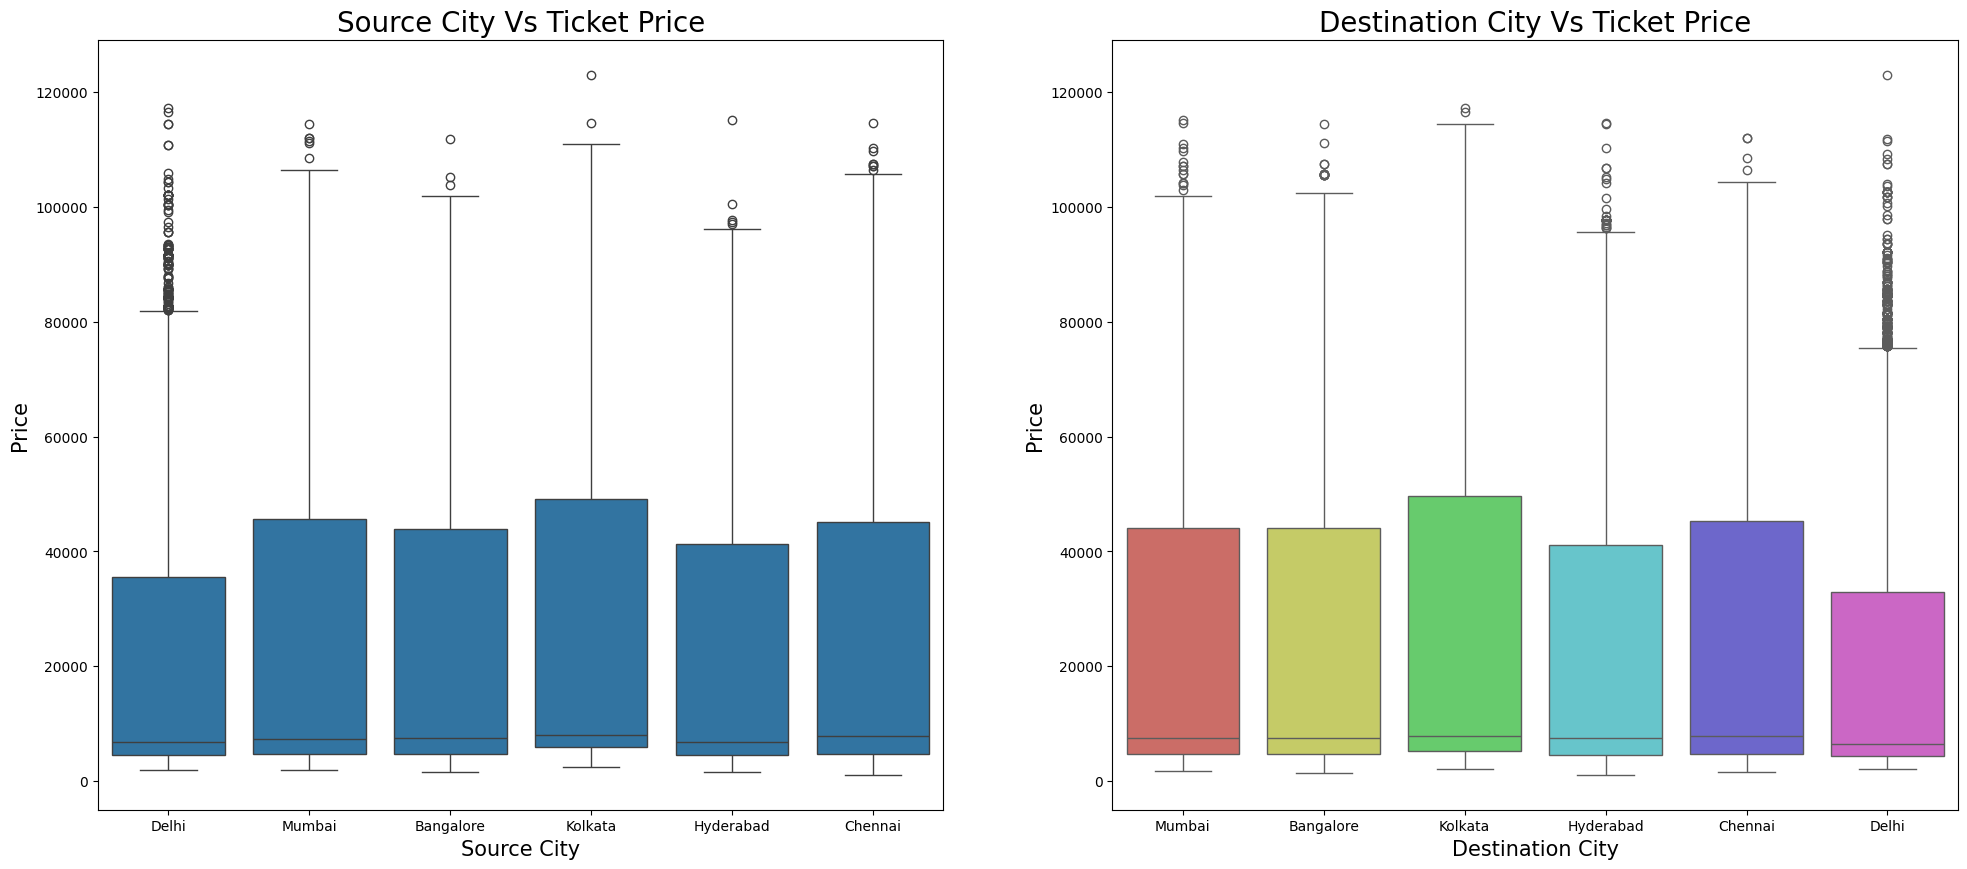

In [ ]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='source_city',y='price',data=df)
plt.title('Source City Vs Ticket Price',fontsize=20)
plt.xlabel('Source City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='destination_city',y='price',data=df,palette='hls')
plt.title('Destination City Vs Ticket Price',fontsize=20)
plt.xlabel('Destination City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<p>
    <b> How Price Varies with the Flight Duration Based on Class?</b>

<li> With increase in Duration, the Ticket Price is also Increases In both the Economy and Business classes</li>
</p>


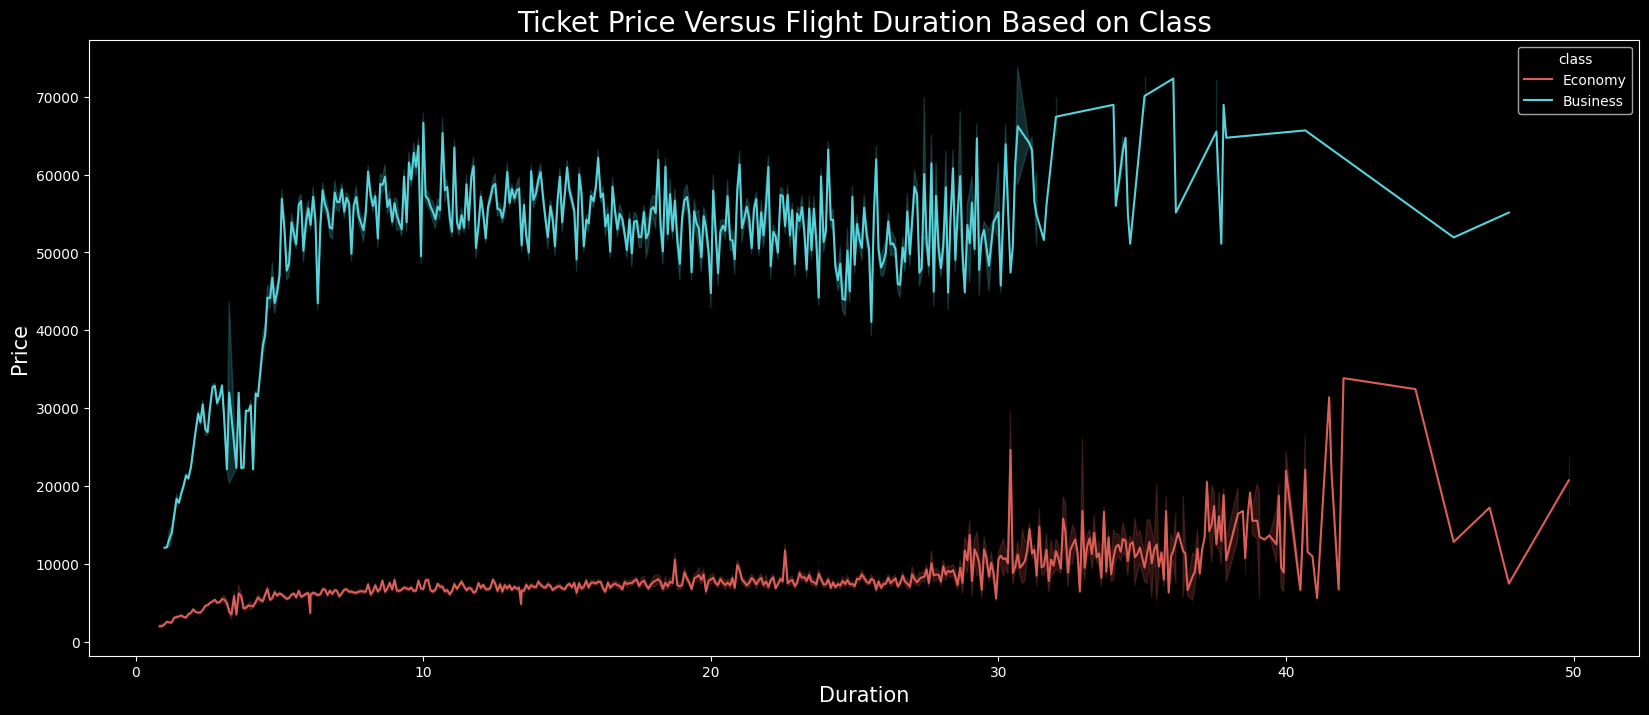

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='duration',y='price',hue='class',palette='hls')
plt.title('Ticket Price Versus Flight Duration Based on Class',fontsize=20)
plt.xlabel('Duration',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<p>
    <b> How does the price affected on the days left for Departure?</b>
    
<li> As we can see when compared to others when there are two days remaining for departure then the Ticket Price is very High for all airlines</li>
    
</p>

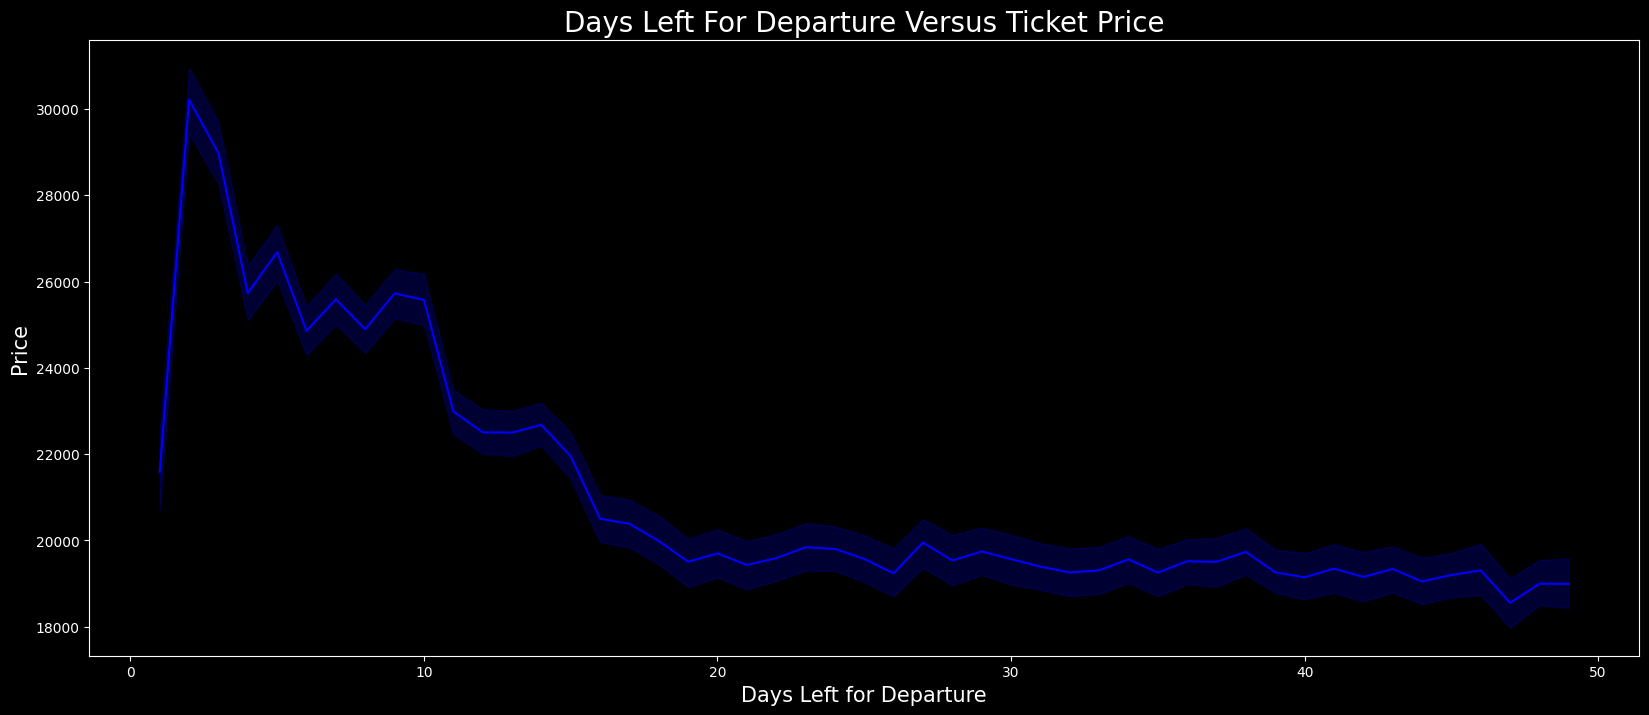

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='days_left',y='price',color='blue')
plt.title('Days Left For Departure Versus Ticket Price',fontsize=20)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

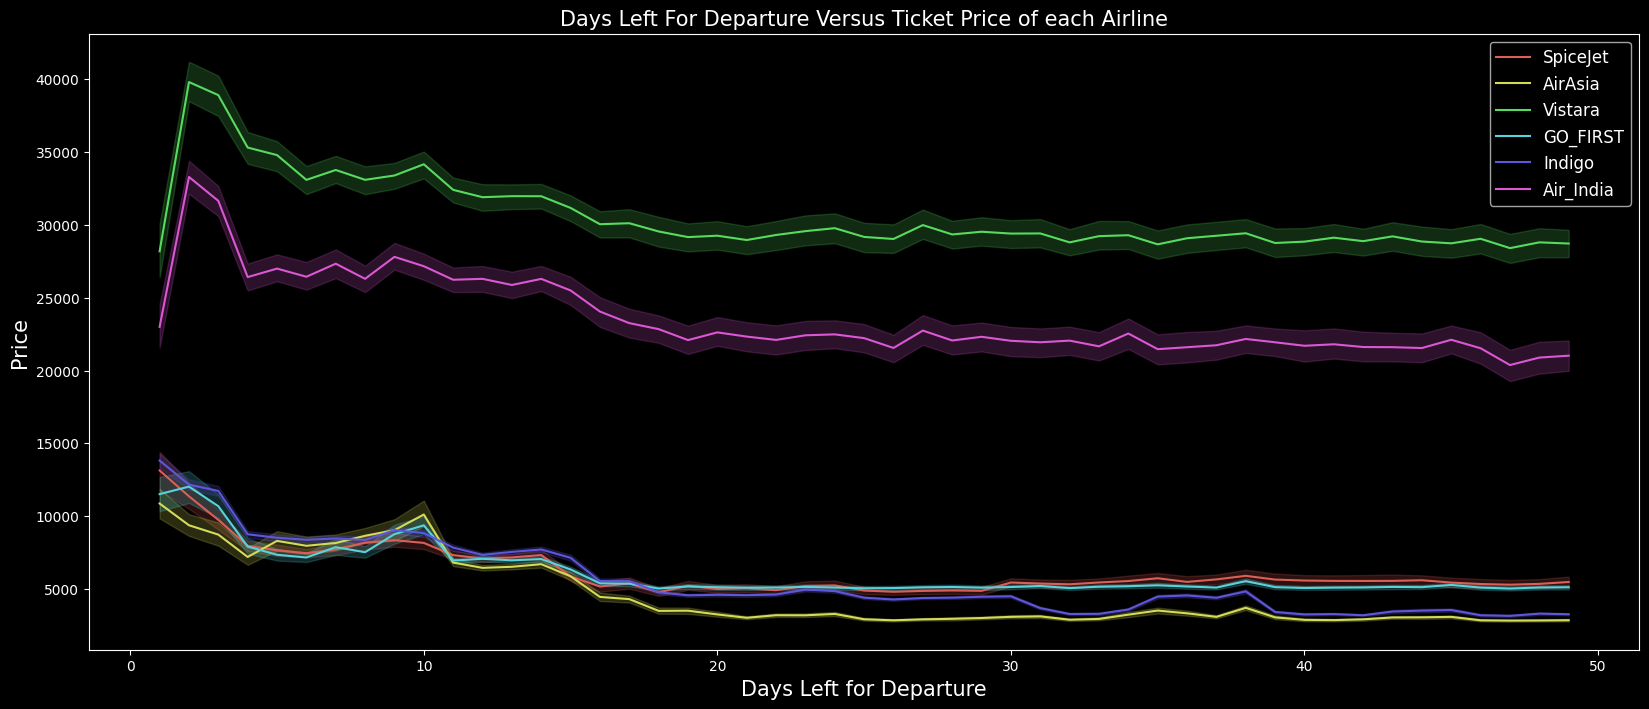

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='days_left',y='price',color='blue',hue='airline',palette='hls')
plt.title('Days Left For Departure Versus Ticket Price of each Airline',fontsize=15)
plt.legend(fontsize=12)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<b> Total number of Flights from one city to another</b>

In [ ]:
df.groupby(['flight','source_city','destination_city','airline','class'],as_index=False).count().groupby(['source_city','destination_city'],as_index=False)['flight'].count().head(10)

,source_city,destination_city,flight
0,Bangalore,Chennai,106
1,Bangalore,Delhi,227
2,Bangalore,Hyderabad,132
3,Bangalore,Kolkata,171
4,Bangalore,Mumbai,175
5,Chennai,Bangalore,69
6,Chennai,Delhi,105
7,Chennai,Hyderabad,82
8,Chennai,Kolkata,110
9,Chennai,Mumbai,94


<b> Average Price of different Airlnes from Source city to Destination city</b>

In [ ]:
df.groupby(['airline','source_city','destination_city'],as_index=False)['price'].mean().head(10)

,airline,source_city,destination_city,price
0,AirAsia,Bangalore,Chennai,2073.043478
1,AirAsia,Bangalore,Delhi,4807.092426
2,AirAsia,Bangalore,Hyderabad,2931.494792
3,AirAsia,Bangalore,Kolkata,4443.468160
4,AirAsia,Bangalore,Mumbai,3342.385350
5,AirAsia,Chennai,Bangalore,1914.760870
6,AirAsia,Chennai,Delhi,3697.314003
7,AirAsia,Chennai,Hyderabad,2053.182540
8,AirAsia,Chennai,Kolkata,3682.338762
9,AirAsia,Chennai,Mumbai,2691.100000


In [ ]:
# Creating a Back up File
df_bk=df.copy()

In [ ]:
# Coverting the labels into a numeric form using Label Encoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=le.fit_transform(df[col])

In [ ]:
# storing the Dependent Variables in X and Independent Variable in Y
x=df.drop(['price'],axis=1)
y=df['price']

In [ ]:
# Splitting the Data into Training set and Testing Set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((210107, 10), (90046, 10), (210107,), (90046,))

In [ ]:
# Scaling the values to convert the int values to Machine Languages
from sklearn.preprocessing import MinMaxScaler
mmscaler=MinMaxScaler(feature_range=(0,1))
x_train=mmscaler.fit_transform(x_train)
x_test=mmscaler.fit_transform(x_test)
x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)

In [ ]:
a={'Model Name':[], 'Mean_Absolute_Error_MAE':[] ,'Adj_R_Square':[] ,'Root_Mean_Squared_Error_RMSE':[] ,'Mean_Absolute_Percentage_Error_MAPE':[] ,'Mean_Squared_Error_MSE':[] ,'Root_Mean_Squared_Log_Error_RMSLE':[] ,'R2_score':[]}
Results=pd.DataFrame(a)
Results.head()

,Model Name,Mean_Absolute_Error_MAE,Adj_R_Square,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score


In [ ]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import numpy as np
import pandas as pd

# Create objects of Regression / Regressor models with default hyper-parameters
modelmlg = LinearRegression()
modeldcr = DecisionTreeRegressor()
modelbag = BaggingRegressor()
modelrfr = RandomForestRegressor()
modelSVR = SVR()
modelXGR = xgb.XGBRegressor()
modelKNN = KNeighborsRegressor(n_neighbors=5)
modelETR = ExtraTreesRegressor()
modelRE = Ridge()
modelLO = linear_model.Lasso(alpha=0.1)

# Corrected GradientBoostingRegressor with valid loss parameter
modelGBR = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                     init=None, random_state=None, max_features=None,
                                     alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

# Evalution matrix for all the algorithms
MM = [modelmlg, modeldcr, modelrfr, modelKNN, modelETR, modelGBR, modelXGR, modelbag, modelRE, modelLO]

# Initialize an empty DataFrame to store results
Results = pd.DataFrame()

for models in MM:
    # Fit the model with train data
    models.fit(x_train, y_train)

    # Predict the model with test data
    y_pred = models.predict(x_test)

    # Print the model name
    print('Model Name: ', models)

    # Evaluation metrics for Regression analysis
    print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred), 3))
    print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred), 3))
    print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))
    print('R2_score:', round(metrics.r2_score(y_test, y_pred), 6))
    print('Root Mean Squared Log Error (RMSLE):', round(np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))), 3))

    # Define the function to calculate the MAPE - Mean Absolute Percentage Error
    def MAPE(y_test, y_pred):
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Evaluation of MAPE
    result = MAPE(y_test, y_pred)
    print('Mean Absolute Percentage Error (MAPE):', round(result, 2), '%')

    # Calculate Adjusted R squared values
    r_squared = round(metrics.r2_score(y_test, y_pred), 6)
    adjusted_r_squared = round(1 - (1 - r_squared) * (len(y_test) - 1) / (len(y_test) - x_train.shape[1] - 1), 6)
    print('Adj R Square: ', adjusted_r_squared)
    print('------------------------------------------------------------------------------------------------------------')

    # Add results to DataFrame
    new_row = {
        'Model Name': str(models),
        'Mean_Absolute_Error_MAE': metrics.mean_absolute_error(y_test, y_pred),
        'Adj_R_Square': adjusted_r_squared,
        'Root_Mean_Squared_Error_RMSE': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        'Mean_Absolute_Percentage_Error_MAPE': result,
        'Mean_Squared_Error_MSE': metrics.mean_squared_error(y_test, y_pred),
        'Root_Mean_Squared_Log_Error_RMSLE': np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),
        'R2_score': metrics.r2_score(y_test, y_pred)
    }
    Results = pd.concat([Results, pd.DataFrame([new_row])], ignore_index=True)



    #------------------------------------------------------------

Model Name:  LinearRegression()
Mean Absolute Error (MAE): 4630.296
Mean Squared Error (MSE): 49070241.265
Root Mean Squared Error (RMSE): 7005.015
R2_score: 0.904656
Root Mean Squared Log Error (RMSLE): 8.854
Mean Absolute Percentage Error (MAPE): 43.89 %
Adj R Square:  0.904645
------------------------------------------------------------------------------------------------------------
Model Name:  DecisionTreeRegressor()
Mean Absolute Error (MAE): 1262.122
Mean Squared Error (MSE): 13785905.343
Root Mean Squared Error (RMSE): 3712.938
R2_score: 0.973214
Root Mean Squared Log Error (RMSLE): 8.22
Mean Absolute Percentage Error (MAPE): 8.63 %
Adj R Square:  0.973211
------------------------------------------------------------------------------------------------------------
Model Name:  RandomForestRegressor()
Mean Absolute Error (MAE): 1168.708
Mean Squared Error (MSE): 8175495.298
Root Mean Squared Error (RMSE): 2859.282
R2_score: 0.984115
Root Mean Squared Log Error (RMSLE): 7.958
Mea

In [ ]:
Results

,Model Name,Mean_Absolute_Error_MAE,Adj_R_Square,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score
0,LinearRegression(),4630.295614,0.904645,7005.015436,43.888567,4.907024e+07,8.854382,0.904656
1,DecisionTreeRegressor(),1262.121747,0.973211,3712.937562,8.629130,1.378591e+07,8.219579,0.973214
2,RandomForestRegressor(),1168.708194,0.984113,2859.282305,7.897045,8.175495e+06,7.958326,0.984115
3,KNeighborsRegressor(),1853.746812,0.971655,3819.270820,11.109409,1.458683e+07,8.247815,0.971658
4,ExtraTreesRegressor(),1144.125400,0.984829,2794.113873,7.634494,7.807072e+06,7.935270,0.984831
5,GradientBoostingRegressor(),2808.067836,0.956819,4713.929007,20.672946,2.222113e+07,8.458277,0.956824
6,"XGBRegressor(base_score=None, booster=None, ca...",1862.407118,0.977301,3417.712919,14.232981,1.168076e+07,8.136727,0.977304
7,BaggingRegressor(),1208.639088,0.982637,2989.167031,8.249122,8.935120e+06,8.002750,0.982639
8,Ridge(),4630.313301,0.904645,7005.011583,43.888754,4.907019e+07,8.854381,0.904656
9,Lasso(alpha=0.1),4630.179207,0.904645,7005.006183,43.885459,4.907011e+07,8.854380,0.904656


In [ ]:
models=['LinearRegression','DecisionTreeRegressor','RandomForestRegressor','KNeighborsRegressor','ExtraTreesRegressor','GradientBoostingRegressor','XGBRegressor','BaggingRegressor','Ridge Regression','Lasso Regression']
result=pd.DataFrame({'Model_Name':models})
result['Adj_R_Square']=Results['Adj_R_Square']
result['Mean_Absolute_Error_MAE']=Results['Mean_Absolute_Error_MAE']
result['Root_Mean_Squared_Error_RMSE']=Results['Root_Mean_Squared_Error_RMSE']
result['Mean_Absolute_Percentage_Error_MAPE']=Results['Mean_Absolute_Percentage_Error_MAPE']
result['Mean_Squared_Error_MSE']=Results['Mean_Squared_Error_MSE']
result['Root_Mean_Squared_Log_Error_RMSLE']=Results['Root_Mean_Squared_Log_Error_RMSLE']
result['R2_score']=Results['R2_score']
result=result.sort_values(by='Adj_R_Square',ascending=False).reset_index(drop=True)
result

,Model_Name,Adj_R_Square,Mean_Absolute_Error_MAE,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score
0,ExtraTreesRegressor,0.984829,1144.125400,2794.113873,7.634494,7.807072e+06,7.935270,0.984831
1,RandomForestRegressor,0.984113,1168.708194,2859.282305,7.897045,8.175495e+06,7.958326,0.984115
2,BaggingRegressor,0.982637,1208.639088,2989.167031,8.249122,8.935120e+06,8.002750,0.982639
3,XGBRegressor,0.977301,1862.407118,3417.712919,14.232981,1.168076e+07,8.136727,0.977304
4,DecisionTreeRegressor,0.973211,1262.121747,3712.937562,8.629130,1.378591e+07,8.219579,0.973214
5,KNeighborsRegressor,0.971655,1853.746812,3819.270820,11.109409,1.458683e+07,8.247815,0.971658
6,GradientBoostingRegressor,0.956819,2808.067836,4713.929007,20.672946,2.222113e+07,8.458277,0.956824
7,LinearRegression,0.904645,4630.295614,7005.015436,43.888567,4.907024e+07,8.854382,0.904656
8,Ridge Regression,0.904645,4630.313301,7005.011583,43.888754,4.907019e+07,8.854381,0.904656
9,Lasso Regression,0.904645,4630.179207,7005.006183,43.885459,4.907011e+07,8.854380,0.904656


In [ ]:
#Trainig the model with
modelETR.fit(x_train, y_train)

# Predict the model with test data

y_pred = modelETR.predict(x_test)

In [ ]:
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=df_bk.merge(out,left_index=True,right_index=True)

In [ ]:
result.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Price_actual,Price_pred
55999,Indigo,6E-5316,Mumbai,Late_Night,zero,Late_Night,Bangalore,Economy,1.58,20,2124,2124,2124.00
50294,Vistara,UK-825,Mumbai,Morning,one,Evening,Delhi,Economy,10.17,37,10895,10895,7553.38
284197,Vistara,UK-870,Hyderabad,Night,one,Night,Kolkata,Business,26.17,27,51819,51819,53687.72
139327,Air_India,AI-763,Kolkata,Early_Morning,one,Late_Night,Bangalore,Economy,17.17,28,7053,7053,7161.68
294619,Vistara,UK-826,Chennai,Afternoon,one,Evening,Bangalore,Business,5.25,25,44144,44144,44144.00
171186,AirAsia,I5-1518,Hyderabad,Evening,one,Morning,Kolkata,Economy,13.25,7,5291,5291,9030.24
39436,Vistara,UK-985,Delhi,Evening,one,Morning,Chennai,Economy,13.00,28,4979,4979,5097.35
42676,Vistara,UK-975,Delhi,Early_Morning,one,Morning,Chennai,Economy,5.83,47,5098,5098,5094.63
101560,Indigo,6E-309,Bangalore,Evening,one,Late_Night,Mumbai,Economy,4.83,43,3957,3957,2612.18
97182,Vistara,UK-866,Bangalore,Night,zero,Night,Mumbai,Economy,1.75,20,2150,2150,2151.02


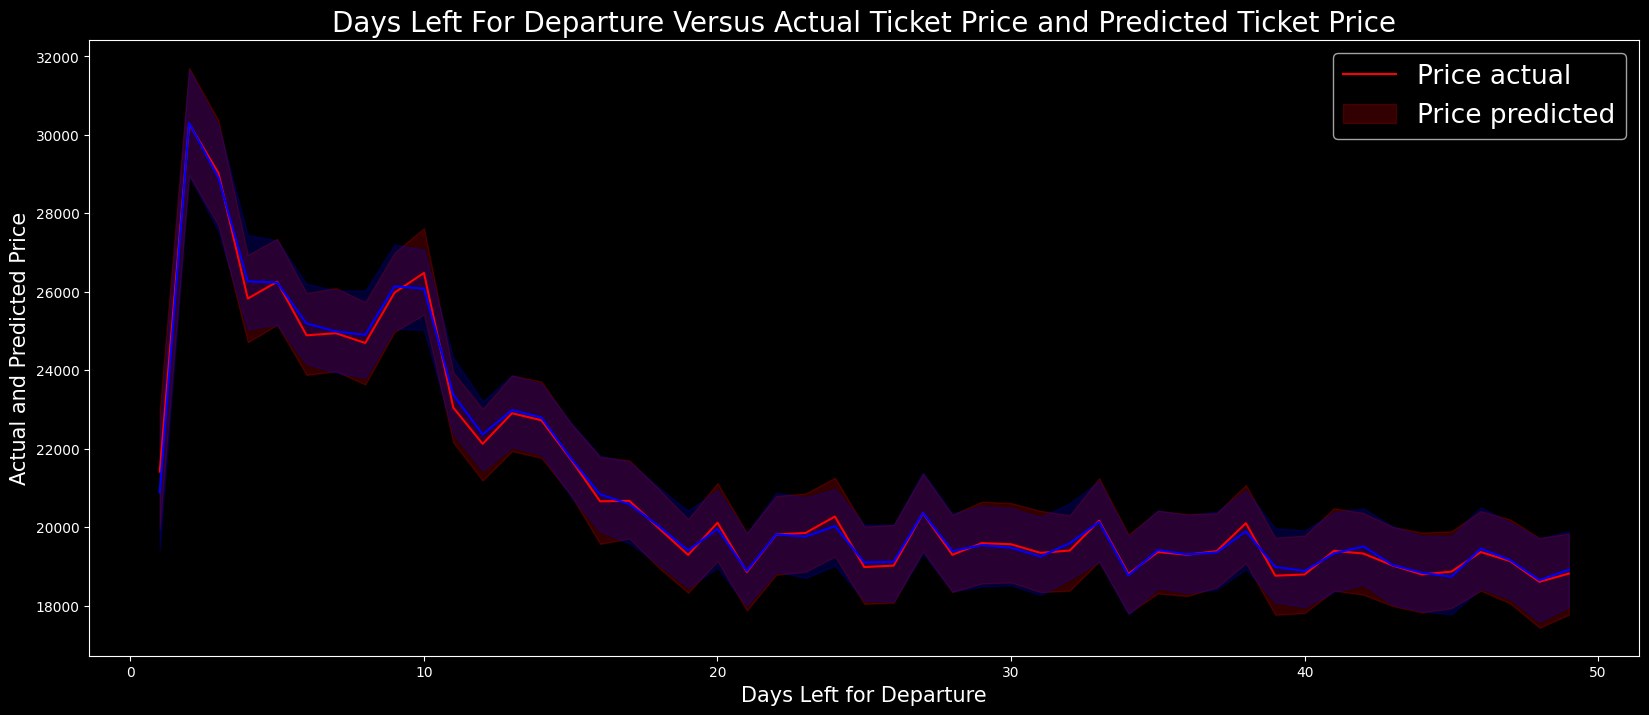

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=result,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=result,x='days_left',y='Price_pred',color='blue')
plt.title('Days Left For Departure Versus Actual Ticket Price and Predicted Ticket Price',fontsize=20)
plt.legend(labels=['Price actual','Price predicted'],fontsize=19)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Actual and Predicted Price',fontsize=15)
plt.show()

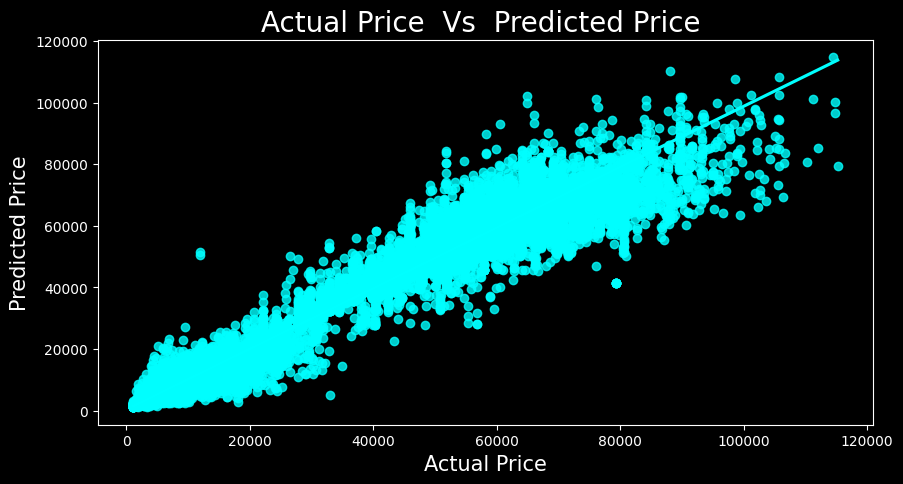

In [ ]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=result,color='cyan')
plt.title('Actual Price  Vs  Predicted Price ',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()